#### @author: Александр Владимирович Толмачев | axtolm@gmail.com
<hr>

## 4. Методы анализа данных на Python

## Часть 6. Прогнозирование с помощью метода ARIMA

### На этом занятии мы планируем научиться:
- Готовить исходные данные для анализа и прогнозирования временных рядов.
- Использовать метод ARIMA в задаче прогнозирования.
- Получать и интерпретировать результаты прогнозирования.

### 1. Набор данных для анализа

**Для примера возьмем датасет с открытыми данными по распространению COVID-19 в России, включающий:**<br>
- количество заражений, 
- количество выздоровлений,
- количество смертельных случаев.

**Сформулируем задачу - временной прогноз количества заражений за день.** 

> Файл с данными в формате xlsx прилагается к материалами лекции.<br> 

Загрузим данные из xlsx файла в таблицу `pandas.DataFrame`<br>

Воспользуемся методом `pandas.read_excel`<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
<br>Далее ссылки на описание используемых методов будут приведены по ходу лекции.

Если файл находится в той же папке, что документ .ipynb, то путь к нему "С:/DIR/SUBDIR/.../filename.ext" можно не прописывать.<br> 

In [1]:
import pandas as pd    # импорт библиотеки
in_file_name = "dataset_6_arima.xlsx"    # имя файла данных 
df_in = pd.read_excel(in_file_name, sheet_name = "covid_data", header = 0, index_col = 0) # загрузка данных в таблицу

Оценим полученные данные по размеру выборки и первым строкам таблицы

In [2]:
print(len(df_in), min(df_in.index).date(), max(df_in.index).date()) # выведем на экран размер выборки и мин/макс даты

580 2020-03-12 2021-10-12


In [3]:
df_in.head(3)    # выведем на экран первые три строки таблицы датафрейма 

,cases,cured,deaths,cases_day,cured_day,deaths_day
date,,,,,,
2020-03-12,34,0,0,34,0,0
2020-03-13,45,0,0,11,0,0
2020-03-14,59,0,0,14,0,0


**Поля (столбцы) таблицы**<br>
- "date" - дата, для которой в строке приведены показатели (индекс DataFrame),
- "cases" - количество заражений нарастающим итогом с 12-03-2020,
- "cured" - количество выздоровлений нарастающим итогом с 12-03-2020,
- "deaths" - количество смертельных случаев нарастающим итогом с 12-03-2020,
- "cases_day" - количество заражений за день,
- "cured_day" - количество выздоровлений за день,
- "deaths_day" - количество смертельных случаев за день.

### 2. Подготовка данных для анализа и прогнозирования временного ряда

**Сформируем временной ряд с интересующим нас показателем - `cases_day` (количество заражений за день).**<br>
**Для обучения модели будем использовать все имеющиеся данные за исключением последнего месяца.**<br>
**Последний месяц оставим для тестирования модели.**

Для выделения последнего месяца воспользуемся классом `timedelta` из модуля `datetime` (поставляется вместе с Python)
https://docs.python.org/3/library/datetime.html    
С его помощью вычтем из максимальной даты в датасете 30 дней

In [4]:
from datetime import timedelta
df_train = df_in[df_in.index < max(df_in.index) - timedelta(days=30)]    # выборка для обучения
df_test = df_in[df_in.index >= max(df_in.index) - timedelta(days=30)]    # выборка для тестирования

Выведем на экран временные границы `df_train` и `df_test`

In [5]:
print("df_train:", min(df_train.index).date(), max(df_train.index).date())
print("df_test:", min(df_test.index).date(), max(df_test.index).date())
print("Все ОК!")

df_train: 2020-03-12 2021-09-11
df_test: 2021-09-12 2021-10-12
Все ОК!


**Для прогнозирования количества заражений за день выделяем колонку `cases_day` в отдельную таблицу pandas.DataFrame и преобразуем ее в одномерную таблицу pandas.Series (индекс - время).**<br>
Используем метод `pandas.DataFrame.squeeze(axis=1)`. Параметр `axis=1` - преобразуем столбец.<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.squeeze.html

In [6]:
ts_train = df_train[['cases_day']].squeeze(axis=1)    # выборка для обучения
ts_test = df_test[['cases_day']].squeeze(axis=1)      # выборка для тестирования

**Выведем на экран тип ts_train и первые три элемента**<br>

In [7]:
print(type(ts_train),ts_train[:3])     # тип ts_train, первые три элемента

<class 'pandas.core.series.Series'> date
2020-03-12    34
2020-03-13    11
2020-03-14    14
Name: cases_day, dtype: int64


**Выведем на экран графики ts_train и ts_test**<br>

Для графика воспользуемся методом `pandas.Series.plot` с параметрами по умолчанию<br>
https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.Series.plot.html

ts_train - выборка для обучения

<AxesSubplot:xlabel='date'>

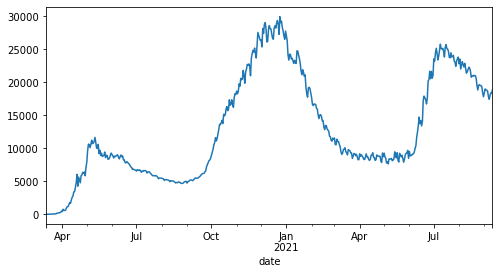

In [8]:
ts_train.plot(figsize=(8, 4))    # график, figsize - размеры картинки

ts_test - выборка для тестирования

<AxesSubplot:xlabel='date'>

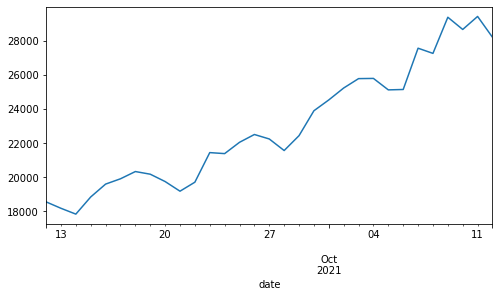

In [9]:
ts_test.plot(figsize=(8, 4))    # figsize - размеры картинки

### 3. Метод ARIMA для прогнозирования временных рядов

ARIMA на английском - это Autoregressive Integrated Moving Average.<br>
Русский вариант - интегрированная модель авторегрессии - скользящего среднего. <br>
Также встречается как модель/метод Бокса-Дженкинса.

Реализация метода ARIMA есть в библиотеке `statsmodels`<br>
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

Класс ARIMA имеет много параметров:

```python
class statsmodels.tsa.arima.model.ARIMA(endog, exog=None, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, enforce_stationarity=True, enforce_invertibility=True, concentrate_scale=False, trend_offset=1, dates=None, freq=None, missing='none', validate_specification=True)
```
Минимальный набор параметров для моделирования: <br>
`ARIMA(endog, order=(p, d, q))`, где<br>
`endog` - array_like - временной ряд процесса - $y$.<br>
`order` - tuple - параметры модели (p,d,q), задаваемые пользователем:
- `p` - порядок авторегрессии (order of the model for the autoregressive), 
- `d` - порядок разностей исходного временного ряда (differences), 
- `q` - порядок скользящего среднего (moving average components).

Задача аналитика - подобрать оптимальные параметры модели. Используя Python, можем сделать это перебором.

In [10]:
# зададим диапазоны значений p, d, q для перебора
p = range(8,10)    # 8..9    
d = range(1,3)     # 1..2
q = range(3,5)     # 3..4

Перебор требует времени, поэтому в лекции мы задали узкие диапазоны для ускорения процесса.

**Сформируем все возможные комбинации значений (p,d,q)**<br>
Воспользуемся итератором `itertools.product`<br>
https://docs.python.org/3/library/itertools.html#itertools.product 

In [11]:
import itertools    # импорт модуля
list_pdq = list(itertools.product(p, d, q))    # запустим итератор и преобразуем результат в список
print(len(list_pdq), list_pdq)    # выведем размер списка и его элементы

8 [(8, 1, 3), (8, 1, 4), (8, 2, 3), (8, 2, 4), (9, 1, 3), (9, 1, 4), (9, 2, 3), (9, 2, 4)]


В качестве критерия оптимальности параметров (p,d,q) будем использовать **Информационный критерий Акаике (AIC)**.<br>
> AIC = Akaike Information Criterion.

AIC оценивает, насколько хорошо модель подходит под данные. Чем меньше AIC – тем точнее модель. 

In [12]:
import numpy as np    # импорт numpy package
best_pdq = (0,0,0)    # стартовое значение для искомой тройки лучших параметров (p,d,q)
best_aic = np.inf     # стартовое значение AIC = плюс бесконечность

**Запустим цикл по всем комбинациям (p,d,q) и выберем тройку с наименьшим AIC**<br>
Создание модели ARIMA (экземпляра класса): `arima_test = ARIMA(ts_train, order = param)`<br>
Обучение модели: `arima_test_result = arima_test.fit()`<br>
Получение AIC из сохраненного результата обучения: `arima_test_result.aic`<br>
Для понимания алгоритма - см. комментарии.

In [13]:
from statsmodels.tsa.arima.model import ARIMA    # импорт класса ARIMA
import warnings
warnings.filterwarnings("ignore")    # изменим параметр фильтрации предупреждений
for param in list_pdq:    # цикл по комбинациям из списка
    arima_test = ARIMA(ts_train, order = param)    # создаем объект ARIMA
    arima_test_result = arima_test.fit()           # обучаем модель
    if arima_test_result.aic < best_aic:      # если текущий результат AIC лучше сохраненного, сохраняем его как лучший 
        best_pdq = param                      # сохраняем (p,d,q)
        best_aic = arima_test_result.aic      # сохраняем AIC

**Выведем значения подобранных (p,d,q) и AIC на экран**

In [14]:
print(best_pdq, round(best_aic,2)) 

(9, 1, 4) 8465.2


**Построим модель ARIMA c подобранными лучшими параметрами (p,d,q)**<br>

In [15]:
arima_final = ARIMA(ts_train, order = best_pdq)    # создаем объект ARIMA 
arima_final_result = arima_final.fit()             # обучаем модель    

**Оценка модели ARIMA**

Воспользуемся графическим методом `plot_diagnostics`<br>
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html
<br>     
Получим набор из 4-х графиков для оценки автокорреляции и распределения остатков:
- Standardized residuals over time.
- Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
- Normal Q-Q plot, with Normal reference line.
- Correlogram.

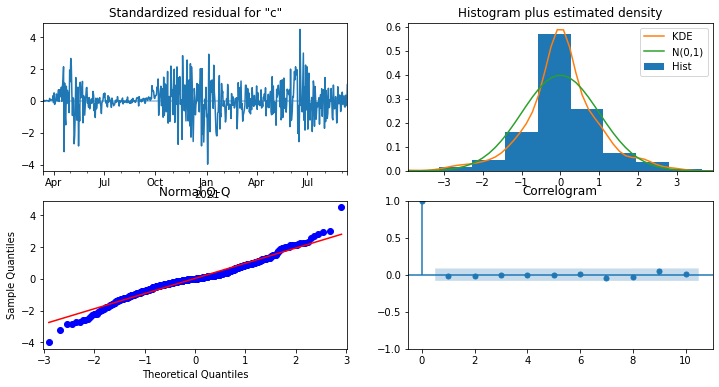

In [16]:
arima_final_result.plot_diagnostics(figsize=(12, 6)).show()    # figsize - размеры картинки

Модель удовлетворительна, если распределение остатков близко к нормальному, а автокорреляция близка к нулю.<br>
Если это не так, с моделью нужно работать дальше, чтобы привести к удовлетворительной.

**Если для оценки модели нужна детальная статистика, то для этого есть метод [ARIMAResults.summary](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.summary.html#statsmodels.tsa.arima.model.ARIMAResults.summary)**<br>
В частности, здесь можно оценить коэффициенты модели и их статистическую значимость по величине p-value.

In [17]:
arima_final_result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              cases_day   No. Observations:                  549
Model:                 ARIMA(9, 1, 4)   Log Likelihood               -4218.602
Date:                Thu, 10 Mar 2022   AIC                           8465.203
Time:                        15:08:12   BIC                           8525.491
Sample:                    03-12-2020   HQIC                          8488.767
                         - 09-11-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5198      0.064      8.156      0.000       0.395       0.645
ar.L2         -1.0452      0.059    -17.616      0.000      -1.162      -0.929
ar.L3          0.6223      0.065      9.594      0.000       0.495       0.749
ar.L4         -0.4913      0.065     -7.527      0.000      -0.619      -0.363
ar.L5         -0.0050      0.058     -0.086      0.932      -0.119       0.109
ar.L6          0.2050      0.061      3.357      0.001       0.085       0.325
ar.L7          0.2693      0.061      4.413      0.000       0.150       0.389
ar.L8          0.1862      0.053      3.529      0.000       0.083       0.290
ar.L9          0.1307      0.055      2.375      0.018       0.023       0.238
ma.L1         -0.7753      0.057    -13.597      0.000      -0.887      -0.664
ma.L2          1.1949      0.050     23.954      0.000       1.097       1.293
ma.L3         -0.8399      0.048    -17.537      0.000      -0.934      -0.746
ma.L4          0.6776      0.046     14.858      0.000       0.588       0.767
sigma2      3.093e+05   1.58e+04     19.547      0.000    2.78e+05     3.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               110.12
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Построим прогнозы с помощью полученной модели ARIMA и сравним их с фактическими значениями
Воспользуемся методом [ARIMAResults.get_prediction](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.get_prediction.html)<br>
**Прогноз #1.** Для последних 50 точек из датасета для обучения `df_train`.<br>
**Прогноз #2.** Для всех 30 точек из датасета для тестирования `df_test`, которые не попали в обучение модели.<br>
Параметр `dynamic = False` отключает динамическое прогнозирование.

**Вычислим прогноз#1 по шагам**

In [18]:
prediction_1 = arima_final_result.get_prediction(start = min(df_train.index),    # посчитаем прогноз#1 для всего интервала
                                                 end = max(df_train.index),      # нужные 50 точек отфильтруем в конце
                                                 dynamic = False)    

Получим средние прогнозируемые значения и границы доверительного интервала

In [19]:
prediction_1_mean = prediction_1.predicted_mean         # средние прогнозируемые значения в формате pandas.Series
prediction_1_conf_interval = prediction_1.conf_int(alpha=0.05)    # границы доверительного интервала в формате pandas.DataFrame

Для визуализации и оценки результатов прогнозирования соберем таблицу `pandas.DataFrame`<br>
**факт - прогноз - границы доверительного интервала** 

In [20]:
df_1_show = prediction_1_conf_interval.copy()    # сделаем копию из таблицы с доверительными интервалами
df_1_show['predicted_value'] = prediction_1_mean # добавим столбец с прогнозом
df_1_show['actual_value'] = ts_train             # добавим столбец с фактическими значениями
df_1_show = df_1_show[-50:]                      # отфильтруем последние 50 
df_1_show[:3]                                    # выведем на экран 3 строки

,lower cases_day,upper cases_day,predicted_value,actual_value
2021-07-24,22787.189452,24967.372809,23877.281131,23947
2021-07-25,22761.216669,24941.400026,23851.308347,24072
2021-07-26,22410.278376,24590.461733,23500.370055,23239


**Визуализируем прогноз#1 и факт**

Воспользуемся библиотекой `matplotlib.pyplot`<br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html

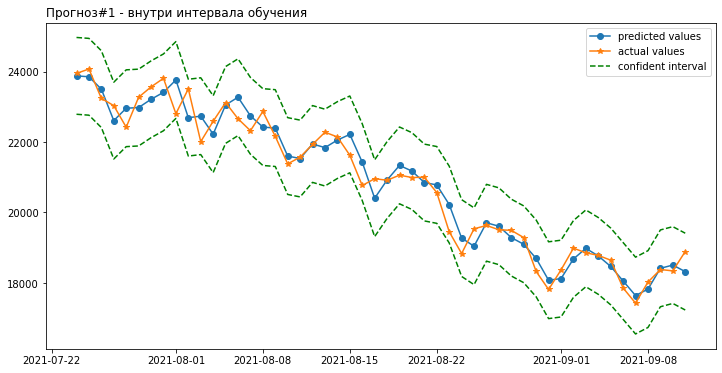

In [21]:
import matplotlib.pyplot as plt    # импорт библиотеки
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_1_show.index, df_1_show['predicted_value'], marker = "o", label = "predicted values")
ax.plot(df_1_show.index, df_1_show['actual_value'], marker = "*", label = "actual values")
ax.plot(df_1_show.index, df_1_show['upper cases_day'], linestyle='dashed', color = 'green', label = "confident interval")
ax.plot(df_1_show.index, df_1_show['lower cases_day'], linestyle='dashed', color = 'green')
ax.legend(loc="best")
plt.title('Прогноз#1 - внутри интервала обучения',loc='left')
plt.show()

Для **количественной оценки качества прогноза** вычислим **среднюю абсолютную процентную ошибку**<br>
Mean Absolute Percentage Error (MAPE):<br>
$MAPE = \frac{1}{N} \sum_{i=1}^{N} |\frac{A_i-P_i}{A_i}|$, где $A_i$ - факт, $P_i$ - прогноз, $N$ - кол-во точек 

In [22]:
df_1_show['mape'] = df_1_show['actual_value'] - df_1_show['predicted_value']    # создадим колонку mape и вычислим разности
df_1_show['mape'] = df_1_show['mape']/df_1_show['actual_value']                 # найдем отношение
df_1_show['mape'] = df_1_show['mape'].abs()*100                                 # возьмем модуль и умножим на 100%
mape_1 = df_1_show['mape'].mean()                                               # вычислим среднее по колонке mape

In [23]:
print('MAPE for the prediction #1:',round(mape_1,2),'%')

MAPE for the prediction #1: 1.5 %


**Выводы по прогнозу#1**<br>
1. Прогноз внутри интервала обучения достаточно хорош.
1. Фактические значения в пределах 95% доверительного интервала.
1. Cредняя абсолютная процентная ошибкя MAPE = 1.5%
1. Прогноз запаздывает относительно фактических значений ("сдвинут" вправо).

**Выполним прогноз#2 по аналогии с предыдущим расчетом**

In [24]:
prediction_2 = arima_final_result.get_prediction(start = min(df_test.index).date(), # посчитаем прогноз#2
                                                 end = max(df_test.index).date(), 
                                                 dynamic = False)

Получим средние прогнозируемые значения и границы доверительного интервала

In [25]:
prediction_2_mean = prediction_2.predicted_mean      # средние прогнозируемые значения в формате pandas.Series   
prediction_2_conf_interval = prediction_2.conf_int(alpha=0.05) # границы доверительного интервала в формате pandas.DataFrame    

Для визуализации и оценки результатов прогнозирования соберем таблицу `pandas.DataFrame`<br>
**факт - прогноз - границы доверительного интервала** 

In [26]:
df_2_show = prediction_2_conf_interval.copy()    # сделаем копию из таблицы с доверительными интервалами
df_2_show['predicted_value'] = prediction_2_mean # добавим столбец с прогнозом
df_2_show['actual_value'] = ts_test              # добавим столбец с фактическими значениями
df_2_show[:3]                                    # выведем на экран 3 строки

,lower cases_day,upper cases_day,predicted_value,actual_value
2021-09-12,17351.137497,19531.320854,18441.229176,18554
2021-09-13,16533.672643,19251.675372,17892.674007,18178
2021-09-14,16095.871684,19280.527394,17688.199539,17837


**Визуализируем прогноз#2 и факт**

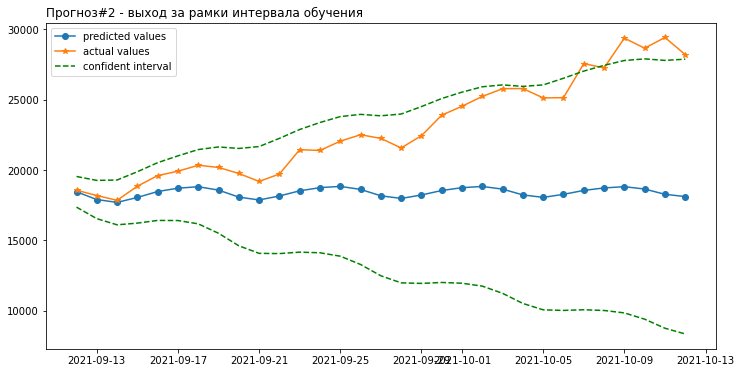

In [27]:
import matplotlib.pyplot as plt    # импорт библиотеки
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_2_show.index, df_2_show['predicted_value'], marker = "o", label = "predicted values")
ax.plot(df_2_show.index, df_2_show['actual_value'], marker = "*", label = "actual values")
ax.plot(df_2_show.index, df_2_show['upper cases_day'], linestyle='dashed', color = 'green', label = "confident interval")
ax.plot(df_2_show.index, df_2_show['lower cases_day'], linestyle='dashed', color = 'green')
ax.legend(loc="best")
plt.title('Прогноз#2 - выход за рамки интервала обучения',loc='left')
plt.show()

Для **количественной оценки качества прогноза** вычислим **среднюю абсолютную процентную ошибку**<br>
Mean Absolute Percentage Error (MAPE) для каждой даты в прогнозе от начала интервала пронозирования.<br>
Получим MAPE в динамике по мере увеличения горизонта прогнозирования.

In [28]:
df_2_show['mape'] = df_2_show['actual_value'] - df_2_show['predicted_value']    # создадим колонку mape и вычислим разности
df_2_show['mape'] = df_2_show['mape']/df_2_show['actual_value']                 # найдем отношение
df_2_show['mape'] = df_2_show['mape'].abs()*100                                 # возьмем модуль и умножим на 100%
df_2_show['mape_cum'] = df_2_show['mape'].cumsum()                              # вычислим кумулятивную сумму 
df_2_show['mape_n'] = list(range(1,len(df_2_show)+1))                           # кумулятивная сумма количества элементов
df_2_show['mape_cum'] = df_2_show['mape_cum']/df_2_show['mape_n']               # MAPE на каждую дату прогноза
df_2_show[:8]                                                                  # выведем первые 8 строк таблицы на экран

,lower cases_day,upper cases_day,predicted_value,actual_value,mape,mape_cum,mape_n
2021-09-12,17351.137497,19531.320854,18441.229176,18554,0.607798,0.607798,1
2021-09-13,16533.672643,19251.675372,17892.674007,18178,1.569623,1.088710,2
2021-09-14,16095.871684,19280.527394,17688.199539,17837,0.834224,1.003881,3
2021-09-15,16217.107847,19868.734114,18042.920980,18841,4.235863,1.811877,4
2021-09-16,16408.793298,20513.152362,18460.972830,19594,5.782521,2.606006,5
2021-09-17,16399.913876,20997.634696,18698.774286,19905,6.059913,3.181657,6
2021-09-18,16164.849863,21444.203279,18804.526571,20329,7.499008,3.798421,7
2021-09-19,15494.372522,21628.728710,18561.550616,20174,7.992710,4.322708,8


**Визуализируем полученную среднюю абсолютную процентную ошибку MAPE для всех точек из тестовой выборки**

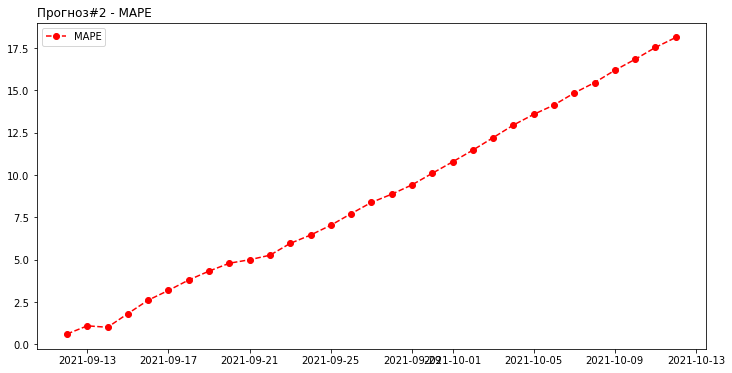

In [29]:
import matplotlib.pyplot as plt    # импорт библиотеки
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_2_show.index, df_2_show['mape_cum'], marker = "o", color = 'red', linestyle='dashed', label = "MAPE")
ax.legend(loc="best")
plt.title('Прогноз#2 - MAPE',loc='left')
plt.show()

**Выводы по прогнозу#2**<br>
1. Прогноз за пределы интервала обучения в начале хорош, но быстро ухудшается.
1. Фактические значения почти везде в пределах 95% доверительного интервала, но он сильно расширяется со временем.
1. Cредняя абсолютная процентная ошибка MAPE на первых 4-х шагах в пределах 2%, но дальше линейно растет.
1. Прогнозировать за пределы интервала обучения с высокой точностью можно на несколько шагов вперед.

### Подведем итоги. На этом занятии мы научились:
- Готовить исходные данные для анализа и прогнозирования временных рядов.
- Использовать модель ARIMA в задаче прогнозирования.
- Получать и интерпретировать результаты прогнозирования.